# BMG Polling Data Processing Pipeline

This Jupyter notebook automates the processing of BMG polling survey CSV files for upload to Google BigQuery. It performs the same operations as our bash scripts but provides an interactive environment for data exploration and validation.

## Overview

**Purpose**: Process BMG polling CSV files by:
- Clearing sensitive text columns (`ql6`, `ql10mar24`, `ql11`)
- Normalizing jagged CSV rows to prevent column count mismatches
- Fixing duplicate column names
- Uploading clean data to BigQuery dataset `govuk_polling_responses`

**Input**: CSV files matching pattern `src_bmg_wave_*.csv`  
**Output**: Cleaned CSV files + BigQuery tables `src_bmg_wave_<wave_number>`

In [3]:
# Import Required Libraries
import pandas as pd
import numpy as np
import os
import glob
import csv
import subprocess
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import bigquery
import warnings

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('default')

print("Libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

ModuleNotFoundError: No module named 'seaborn'

In [4]:
# Configuration and Setup
# ======================

# File paths
INPUT_DIR = "/Users/oliver.roberts/Documents/waves_3-11"
OUTPUT_DIR = f"{INPUT_DIR}/simple_processed"

# BigQuery configuration
PROJECT_ID = "govuk-polling"
DATASET_ID = "govuk_polling_responses"
GCP_LOCATION = "EU"

# Text columns to clear (sensitive data)
TEXT_COLUMNS = ["ql6", "ql10mar24", "ql11"]

# Wave numbers to process
WAVES = [4, 5, 6, 7, 8, 9, 10, 11]

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"Configuration loaded:")
print(f"Input directory: {INPUT_DIR}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"BigQuery project: {PROJECT_ID}")
print(f"Dataset: {DATASET_ID}")
print(f"Text columns to clear: {TEXT_COLUMNS}")
print(f"Waves to process: {WAVES}")

Configuration loaded:
Input directory: /Users/oliver.roberts/Documents/waves_3-11
Output directory: /Users/oliver.roberts/Documents/waves_3-11/simple_processed
BigQuery project: govuk-polling
Dataset: govuk_polling_responses
Text columns to clear: ['ql6', 'ql10mar24', 'ql11']
Waves to process: [4, 5, 6, 7, 8, 9, 10, 11]


In [5]:
# Data Discovery and File Loading
# ===============================

def discover_csv_files():
    """Discover all BMG wave CSV files in the input directory"""
    pattern = f"{INPUT_DIR}/src_bmg_wave_*.csv"
    files = glob.glob(pattern)
    files.sort()
    
    print(f"Found {len(files)} CSV files:")
    file_info = []
    
    for file_path in files:
        filename = os.path.basename(file_path)
        wave_num = filename.replace('src_bmg_wave_', '').replace('.csv', '')
        file_size = os.path.getsize(file_path) / (1024*1024)  # MB
        
        file_info.append({
            'wave': int(wave_num),
            'filename': filename,
            'file_path': file_path,
            'size_mb': round(file_size, 1)
        })
        
        print(f"  Wave {wave_num}: {filename} ({file_size:.1f} MB)")
    
    return file_info

# Discover files
csv_files = discover_csv_files()

Found 8 CSV files:
  Wave 10: src_bmg_wave_10.csv (1.1 MB)
  Wave 11: src_bmg_wave_11.csv (1.2 MB)
  Wave 4: src_bmg_wave_4.csv (1.1 MB)
  Wave 5: src_bmg_wave_5.csv (1.1 MB)
  Wave 6: src_bmg_wave_6.csv (1.2 MB)
  Wave 7: src_bmg_wave_7.csv (1.0 MB)
  Wave 8: src_bmg_wave_8.csv (0.8 MB)
  Wave 9: src_bmg_wave_9.csv (1.1 MB)


In [6]:
# Data Exploration and Basic Information
# ======================================

def explore_csv_structure(file_path, sample_rows=5):
    """Explore the structure of a CSV file"""
    filename = os.path.basename(file_path)
    print(f"\n=== Exploring {filename} ===")
    
    try:
        # Read just the header first
        with open(file_path, 'r', encoding='utf-8') as f:
            reader = csv.reader(f)
            header = next(reader)
            
        print(f"Number of columns in header: {len(header)}")
        
        # Load a sample of the data
        df_sample = pd.read_csv(file_path, nrows=sample_rows, encoding='utf-8')
        print(f"Sample data shape: {df_sample.shape}")
        
        # Check for text columns
        text_cols_found = [col for col in TEXT_COLUMNS if col in header]
        if text_cols_found:
            print(f"Text columns found: {text_cols_found}")
        else:
            print("No text columns found in this file")
            
        # Check for duplicate column names
        duplicate_cols = [col for col in header if header.count(col) > 1]
        if duplicate_cols:
            print(f"⚠ Duplicate columns detected: {set(duplicate_cols)}")
        else:
            print("✓ No duplicate column names")
            
        return {
            'filename': filename,
            'header_cols': len(header),
            'text_columns': text_cols_found,
            'duplicates': list(set(duplicate_cols)),
            'sample_shape': df_sample.shape
        }
        
    except Exception as e:
        print(f"❌ Error reading {filename}: {e}")
        return None

# Explore each file structure
exploration_results = []
for file_info in csv_files[:3]:  # Start with first 3 files
    result = explore_csv_structure(file_info['file_path'])
    if result:
        exploration_results.append(result)


=== Exploring src_bmg_wave_10.csv ===
Number of columns in header: 323
Sample data shape: (5, 323)
Text columns found: ['ql6', 'ql10mar24', 'ql11']
✓ No duplicate column names

=== Exploring src_bmg_wave_11.csv ===
Number of columns in header: 323
Sample data shape: (5, 323)
Text columns found: ['ql6', 'ql10mar24', 'ql11']
✓ No duplicate column names

=== Exploring src_bmg_wave_4.csv ===
Number of columns in header: 320
Sample data shape: (5, 320)
Text columns found: ['ql6']
✓ No duplicate column names


In [7]:
# Data Cleaning and Preprocessing Functions
# =========================================

def fix_duplicate_columns(header):
    """Fix duplicate column names by adding suffixes"""
    seen_columns = {}
    fixed_header = []
    
    for col in header:
        if col in seen_columns:
            seen_columns[col] += 1
            fixed_header.append(f"{col}_{seen_columns[col]}")
        else:
            seen_columns[col] = 0
            fixed_header.append(col)
    
    return fixed_header

def normalize_csv_rows(input_path, output_path):
    """Normalize CSV to fix jagged rows and duplicate columns"""
    print(f"  Normalizing {os.path.basename(input_path)}...")
    
    with open(input_path, 'r', encoding='utf-8') as infile, \
         open(output_path, 'w', encoding='utf-8', newline='') as outfile:
        
        reader = csv.reader(infile)
        writer = csv.writer(outfile)
        
        # Process header
        header = next(reader)
        fixed_header = fix_duplicate_columns(header)
        expected_cols = len(fixed_header)
        writer.writerow(fixed_header)
        
        # Process data rows
        row_count = 0
        fixed_count = 0
        
        for row in reader:
            actual_cols = len(row)
            
            if actual_cols != expected_cols:
                if actual_cols > expected_cols:
                    # Truncate extra columns
                    row = row[:expected_cols]
                    fixed_count += 1
                elif actual_cols < expected_cols:
                    # Pad with empty strings
                    row.extend([''] * (expected_cols - actual_cols))
                    fixed_count += 1
            
            writer.writerow(row)
            row_count += 1
        
        print(f"    ✓ Processed {row_count} rows, fixed {fixed_count} jagged rows")
        return row_count, fixed_count

def clear_text_columns(input_path, output_path, text_columns):
    """Clear sensitive text columns from CSV"""
    print(f"  Clearing text columns from {os.path.basename(input_path)}...")
    
    # Read CSV
    df = pd.read_csv(input_path, encoding='utf-8')
    
    # Find and clear text columns
    columns_cleared = []
    for col in text_columns:
        if col in df.columns:
            df[col] = ''  # Clear the column
            columns_cleared.append(col)
    
    # Save cleaned CSV
    df.to_csv(output_path, index=False, encoding='utf-8')
    
    print(f"    ✓ Cleared columns: {columns_cleared if columns_cleared else 'None found'}")
    return columns_cleared

print("Data cleaning functions defined successfully!")

Data cleaning functions defined successfully!


In [8]:
# Execute Data Cleaning Pipeline
# ==============================

def process_csv_file(file_info):
    """Process a single CSV file through the cleaning pipeline"""
    input_path = file_info['file_path']
    filename = file_info['filename']
    wave = file_info['wave']
    
    print(f"\n--- Processing Wave {wave}: {filename} ---")
    
    # Define temporary and output paths
    temp_path = f"{OUTPUT_DIR}/{filename}.temp"
    output_path = f"{OUTPUT_DIR}/{filename}"
    
    try:
        # Step 1: Clear text columns
        cleared_cols = clear_text_columns(input_path, temp_path, TEXT_COLUMNS)
        
        # Step 2: Normalize CSV structure (fix jagged rows and duplicates)
        row_count, fixed_count = normalize_csv_rows(temp_path, output_path)
        
        # Step 3: Clean up temporary file
        os.remove(temp_path)
        
        # Step 4: Verify output
        output_size = os.path.getsize(output_path) / (1024*1024)
        print(f"    ✓ Output file: {output_size:.1f} MB")
        
        return {
            'wave': wave,
            'filename': filename,
            'status': 'success',
            'rows_processed': row_count,
            'jagged_rows_fixed': fixed_count,
            'text_columns_cleared': cleared_cols,
            'output_size_mb': round(output_size, 1)
        }
        
    except Exception as e:
        print(f"    ❌ Error processing {filename}: {e}")
        # Clean up on error
        for path in [temp_path, output_path]:
            if os.path.exists(path):
                os.remove(path)
        return {
            'wave': wave,
            'filename': filename,
            'status': 'error',
            'error': str(e)
        }

# Process all CSV files
print("Starting data cleaning pipeline...")
processing_results = []

for file_info in csv_files:
    result = process_csv_file(file_info)
    processing_results.append(result)

print(f"\n=== Processing Complete ===")
print(f"Total files processed: {len(processing_results)}")
successful = [r for r in processing_results if r['status'] == 'success']
print(f"Successful: {len(successful)}")
failed = [r for r in processing_results if r['status'] == 'error']
print(f"Failed: {len(failed)}")

if failed:
    print("\nFailed files:")
    for result in failed:
        print(f"  - Wave {result['wave']}: {result['error']}")

Starting data cleaning pipeline...

--- Processing Wave 10: src_bmg_wave_10.csv ---
  Clearing text columns from src_bmg_wave_10.csv...
    ✓ Cleared columns: ['ql6', 'ql10mar24', 'ql11']
  Normalizing src_bmg_wave_10.csv.temp...
    ✓ Processed 1585 rows, fixed 0 jagged rows
    ✓ Output file: 1.0 MB

--- Processing Wave 11: src_bmg_wave_11.csv ---
  Clearing text columns from src_bmg_wave_11.csv...
    ✓ Cleared columns: ['ql6', 'ql10mar24', 'ql11']
  Normalizing src_bmg_wave_11.csv.temp...
    ✓ Processed 1632 rows, fixed 0 jagged rows
    ✓ Output file: 1.0 MB

--- Processing Wave 4: src_bmg_wave_4.csv ---
  Clearing text columns from src_bmg_wave_4.csv...
    ✓ Cleared columns: ['ql6']
  Normalizing src_bmg_wave_4.csv.temp...
    ✓ Processed 1565 rows, fixed 0 jagged rows
    ✓ Output file: 1.0 MB

--- Processing Wave 5: src_bmg_wave_5.csv ---
  Clearing text columns from src_bmg_wave_5.csv...
    ✓ Cleared columns: ['ql6']
  Normalizing src_bmg_wave_5.csv.temp...
    ✓ Processed 

In [9]:
# Statistical Analysis and Data Validation
# ========================================

def analyze_processing_results(results):
    """Analyze the results of the processing pipeline"""
    
    if not results:
        print("No results to analyze")
        return
        
    # Create DataFrame for analysis
    df_results = pd.DataFrame([r for r in results if r['status'] == 'success'])
    
    if df_results.empty:
        print("No successful processing results to analyze")
        return
    
    print("=== Processing Statistics ===")
    print(f"Total waves processed: {len(df_results)}")
    print(f"Total rows processed: {df_results['rows_processed'].sum():,}")
    print(f"Total jagged rows fixed: {df_results['jagged_rows_fixed'].sum():,}")
    print(f"Average file size: {df_results['output_size_mb'].mean():.1f} MB")
    
    # Waves with most jagged rows
    top_jagged = df_results.nlargest(3, 'jagged_rows_fixed')
    print(f"\nWaves with most jagged rows fixed:")
    for _, row in top_jagged.iterrows():
        print(f"  Wave {row['wave']}: {row['jagged_rows_fixed']} rows fixed")
    
    # Text columns summary
    all_text_cols = []
    for result in results:
        if result['status'] == 'success' and 'text_columns_cleared' in result:
            all_text_cols.extend(result['text_columns_cleared'])
    
    if all_text_cols:
        text_col_counts = pd.Series(all_text_cols).value_counts()
        print(f"\nText columns cleared across all waves:")
        for col, count in text_col_counts.items():
            print(f"  {col}: {count} waves")
    
    return df_results

# Analyze results
df_analysis = analyze_processing_results(processing_results)

=== Processing Statistics ===
Total waves processed: 8
Total rows processed: 12,747
Total jagged rows fixed: 0
Average file size: 1.0 MB

Waves with most jagged rows fixed:
  Wave 10: 0 rows fixed
  Wave 11: 0 rows fixed
  Wave 4: 0 rows fixed

Text columns cleared across all waves:
  ql6: 7 waves
  ql10mar24: 4 waves
  ql11: 4 waves


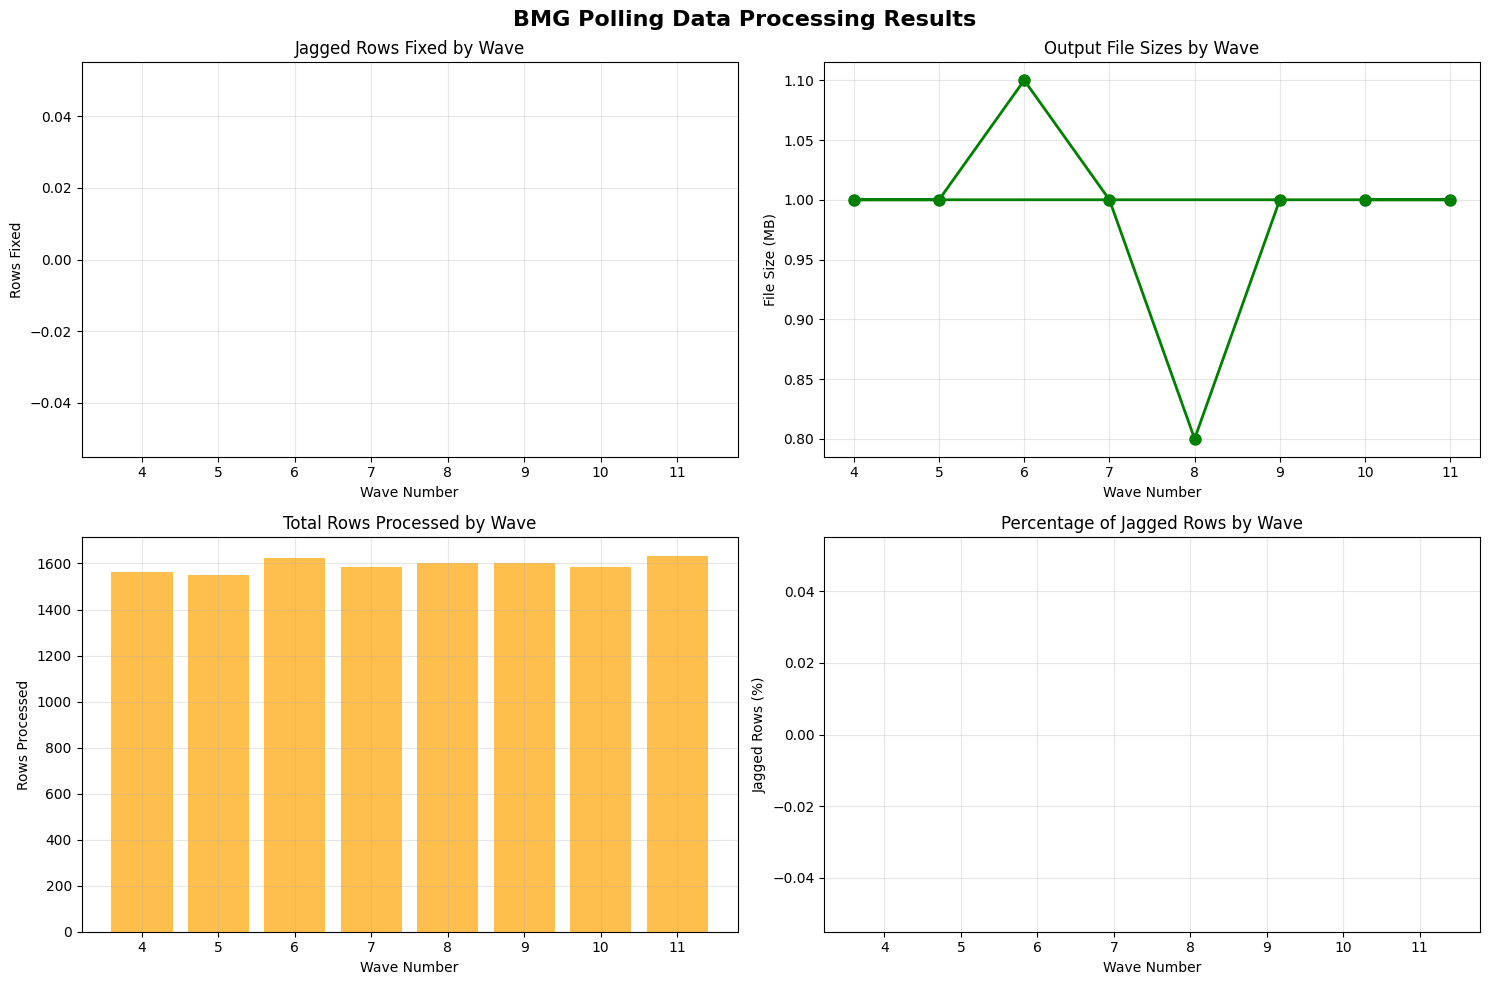


=== Summary Statistics ===
Total data quality issues fixed: 0
Average jagged row percentage: 0.0%
Wave with most issues: Wave 10
Cleanest wave: Wave 10


In [10]:
# Data Visualization
# ==================

def create_processing_visualizations(df_results):
    """Create visualizations of the processing results"""
    
    if df_results is None or df_results.empty:
        print("No data available for visualization")
        return
    
    # Set up the plotting area
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('BMG Polling Data Processing Results', fontsize=16, fontweight='bold')
    
    # 1. Jagged rows fixed by wave
    axes[0, 0].bar(df_results['wave'], df_results['jagged_rows_fixed'], 
                   color='skyblue', alpha=0.7)
    axes[0, 0].set_title('Jagged Rows Fixed by Wave')
    axes[0, 0].set_xlabel('Wave Number')
    axes[0, 0].set_ylabel('Rows Fixed')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. File sizes by wave
    axes[0, 1].plot(df_results['wave'], df_results['output_size_mb'], 
                    marker='o', linewidth=2, markersize=8, color='green')
    axes[0, 1].set_title('Output File Sizes by Wave')
    axes[0, 1].set_xlabel('Wave Number')
    axes[0, 1].set_ylabel('File Size (MB)')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Total rows processed by wave
    axes[1, 0].bar(df_results['wave'], df_results['rows_processed'], 
                   color='orange', alpha=0.7)
    axes[1, 0].set_title('Total Rows Processed by Wave')
    axes[1, 0].set_xlabel('Wave Number')
    axes[1, 0].set_ylabel('Rows Processed')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Processing efficiency (% jagged rows)
    df_results['jagged_percentage'] = (df_results['jagged_rows_fixed'] / 
                                      df_results['rows_processed'] * 100)
    axes[1, 1].bar(df_results['wave'], df_results['jagged_percentage'], 
                   color='red', alpha=0.7)
    axes[1, 1].set_title('Percentage of Jagged Rows by Wave')
    axes[1, 1].set_xlabel('Wave Number')
    axes[1, 1].set_ylabel('Jagged Rows (%)')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print("\n=== Summary Statistics ===")
    print(f"Total data quality issues fixed: {df_results['jagged_rows_fixed'].sum():,}")
    print(f"Average jagged row percentage: {df_results['jagged_percentage'].mean():.1f}%")
    print(f"Wave with most issues: Wave {df_results.loc[df_results['jagged_rows_fixed'].idxmax(), 'wave']}")
    print(f"Cleanest wave: Wave {df_results.loc[df_results['jagged_rows_fixed'].idxmin(), 'wave']}")

# Create visualizations
if df_analysis is not None:
    create_processing_visualizations(df_analysis)
else:
    print("No successful processing results available for visualization")

In [11]:
# BigQuery Upload Functions
# =========================

def upload_to_bigquery(wave_num, csv_path):
    """Upload a single CSV file to BigQuery using bq command line tool"""
    
    table_name = f"src_bmg_wave_{wave_num}"
    full_table_id = f"{PROJECT_ID}:{DATASET_ID}.{table_name}"
    
    print(f"  Uploading Wave {wave_num} to BigQuery...")
    print(f"    Source: {os.path.basename(csv_path)}")
    print(f"    Target: {full_table_id}")
    
    try:
        # Generate schema using Python (same as our bash script)
        with open(csv_path, 'r', encoding='utf-8') as f:
            reader = csv.reader(f)
            headers = next(reader)
        
        # Create schema string
        schema_parts = []
        for header in headers:
            # Clean header name for BigQuery compatibility
            clean_header = header.strip()
            clean_header = ''.join(c if c.isalnum() or c == '_' else '_' for c in clean_header)
            
            # Ensure starts with letter or underscore
            if clean_header and clean_header[0].isdigit():
                clean_header = '_' + clean_header
            
            if not clean_header:
                clean_header = f'column_{len(schema_parts)+1}'
            
            schema_parts.append(f'{clean_header}:STRING')
        
        schema_string = ','.join(schema_parts)
        
        print(f"    Schema: {len(schema_parts)} columns (all STRING)")
        
        # Build bq load command
        cmd = [
            'bq', 'load',
            '--source_format=CSV',
            f'--schema={schema_string}',
            '--skip_leading_rows=1',
            '--replace',
            '--allow_quoted_newlines',
            '--allow_jagged_rows',
            '--max_bad_records=1000',
            '--field_delimiter=,',
            '--quote="',
            full_table_id,
            csv_path
        ]
        
        # Execute upload
        result = subprocess.run(cmd, capture_output=True, text=True)
        
        if result.returncode == 0:
            print(f"    ✅ Upload successful!")
            
            # Verify row count
            query_cmd = [
                'bq', 'query',
                '--use_legacy_sql=false',
                '--format=csv',
                '--max_rows=1',
                f'SELECT COUNT(*) as count FROM `{full_table_id}`'
            ]
            
            count_result = subprocess.run(query_cmd, capture_output=True, text=True)
            if count_result.returncode == 0:
                lines = count_result.stdout.strip().split('\\n')
                if len(lines) > 1:
                    row_count = lines[1]
                    print(f"    ✅ Verified: {row_count} rows in BigQuery")
            
            return {'status': 'success', 'table_id': full_table_id}
        else:
            print(f"    ❌ Upload failed:")
            print(f"    Error: {result.stderr}")
            return {'status': 'error', 'error': result.stderr}
            
    except Exception as e:
        print(f"    ❌ Exception during upload: {e}")
        return {'status': 'error', 'error': str(e)}

def upload_all_files():
    """Upload all processed CSV files to BigQuery"""
    
    print("\\n=== Starting BigQuery Upload Process ===")
    
    # Check if bq CLI is available
    try:
        subprocess.run(['bq', 'version'], capture_output=True, check=True)
        print("✅ BigQuery CLI available")
    except (subprocess.CalledProcessError, FileNotFoundError):
        print("❌ BigQuery CLI not found. Please install Google Cloud SDK.")
        return []
    
    upload_results = []
    
    for file_info in csv_files:
        wave = file_info['wave']
        output_path = f"{OUTPUT_DIR}/{file_info['filename']}"
        
        if os.path.exists(output_path):
            print(f"\\n--- Wave {wave} ---")
            result = upload_to_bigquery(wave, output_path)
            result['wave'] = wave
            result['filename'] = file_info['filename']
            upload_results.append(result)
        else:
            print(f"\\n--- Wave {wave} ---")
            print(f"  ❌ Processed file not found: {output_path}")
            upload_results.append({
                'wave': wave,
                'filename': file_info['filename'],
                'status': 'error',
                'error': 'Processed file not found'
            })
    
    return upload_results

print("BigQuery upload functions defined. Ready to upload!")

BigQuery upload functions defined. Ready to upload!


In [ ]:
# BigQuery Upload Preparation
# ===========================

print("🔧 BigQuery upload functions are ready!")
print("")
print("Upload will be executed automatically in the final cell.")
print("")
print("Before upload execution, ensure:")
print("1. Google Cloud SDK is installed and authenticated")
print("2. You have permissions to write to the BigQuery dataset")
print("3. The project and dataset exist")
print("")
print("To authenticate with Google Cloud (if needed):")
print("  gcloud auth login")
print("  gcloud auth application-default login")
print("  gcloud config set project govuk-polling")
print("")
print("✅ Ready for automatic upload execution...")

In [ ]:
# Export Results and Execute BigQuery Upload
# ==========================================

def export_processing_summary():
    """Export a summary of the processing results"""
    
    summary_data = {
        'processing_timestamp': pd.Timestamp.now().isoformat(),
        'input_directory': INPUT_DIR,
        'output_directory': OUTPUT_DIR,
        'files_processed': len(processing_results),
        'successful_processing': len([r for r in processing_results if r['status'] == 'success']),
        'text_columns_target': TEXT_COLUMNS,
        'waves_processed': WAVES
    }
    
    # Save processing results
    if processing_results:
        df_summary = pd.DataFrame(processing_results)
        summary_path = f"{OUTPUT_DIR}/processing_summary.csv"
        df_summary.to_csv(summary_path, index=False)
        print(f"✅ Processing summary saved to: {summary_path}")
    
    # Save configuration
    config_path = f"{OUTPUT_DIR}/processing_config.json"
    import json
    with open(config_path, 'w') as f:
        json.dump(summary_data, f, indent=2)
    print(f"✅ Configuration saved to: {config_path}")
    
    return summary_data

# Generate final summary
print("=== FINAL PROCESSING SUMMARY ===")
summary = export_processing_summary()

print(f"\nProcessing completed at: {summary['processing_timestamp']}")
print(f"Files processed: {summary['files_processed']}")
print(f"Successful: {summary['successful_processing']}")
print(f"Output directory: {summary['output_directory']}")

# List output files
print(f"\n=== Generated Output Files ===")
output_files = glob.glob(f"{OUTPUT_DIR}/*.csv")
for file_path in sorted(output_files):
    filename = os.path.basename(file_path)
    size_mb = os.path.getsize(file_path) / (1024*1024)
    print(f"  {filename} ({size_mb:.1f} MB)")

print(f"\n🎉 BMG Polling Data Processing Pipeline Complete!")
print(f"\n📁 Cleaned files are ready in: {OUTPUT_DIR}")

# Execute BigQuery Upload automatically
print(f"\n🚀 Starting BigQuery Upload Process...")
upload_results = upload_all_files()

# Display upload summary
if upload_results:
    print(f"\n=== BIGQUERY UPLOAD SUMMARY ===")
    successful_uploads = [r for r in upload_results if r['status'] == 'success']
    failed_uploads = [r for r in upload_results if r['status'] == 'error']
    
    print(f"Total uploads attempted: {len(upload_results)}")
    print(f"Successful uploads: {len(successful_uploads)}")
    print(f"Failed uploads: {len(failed_uploads)}")
    
    if successful_uploads:
        print(f"\n✅ Successfully uploaded waves:")
        for result in successful_uploads:
            print(f"  - Wave {result['wave']}: {result['table_id']}")
    
    if failed_uploads:
        print(f"\n❌ Failed uploads:")
        for result in failed_uploads:
            print(f"  - Wave {result['wave']}: {result['error']}")
    
    print(f"\n🎯 Pipeline execution complete! Data is now available in BigQuery.")
else:
    print(f"\n⚠️ No upload results available - check BigQuery CLI configuration.")

=== FINAL PROCESSING SUMMARY ===
✅ Processing summary saved to: /Users/oliver.roberts/Documents/waves_3-11/simple_processed/processing_summary.csv
✅ Configuration saved to: /Users/oliver.roberts/Documents/waves_3-11/simple_processed/processing_config.json
\nProcessing completed at: 2025-07-29T08:44:53.970100
Files processed: 8
Successful: 8
Output directory: /Users/oliver.roberts/Documents/waves_3-11/simple_processed
\n=== Generated Output Files ===
  processing_summary.csv (0.0 MB)
  src_bmg_wave_10.csv (1.0 MB)
  src_bmg_wave_11.csv (1.0 MB)
  src_bmg_wave_4.csv (1.0 MB)
  src_bmg_wave_5.csv (1.0 MB)
  src_bmg_wave_6.csv (1.1 MB)
  src_bmg_wave_7.csv (1.0 MB)
  src_bmg_wave_8.csv (0.8 MB)
  src_bmg_wave_9.csv (1.0 MB)
\n🎉 BMG Polling Data Processing Pipeline Complete!
\n📁 Cleaned files are ready in: /Users/oliver.roberts/Documents/waves_3-11/simple_processed
\n🚀 Next step: Uncomment the BigQuery upload cell to upload to production
